In [1]:

from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [2]:
import os
from dotenv import load_dotenv

def ensure_api_keys() -> tuple[str, str]:

    load_dotenv()

    required_vars = ["GOOGLE_API_KEY"]
    missing = []

    for var in required_vars:
        if not os.environ.get(var):
            missing.append(var)

    if missing:
        missing_list = ", ".join(missing)
        raise EnvironmentError(
            f"Missing required environment variables: {missing_list}. "
            "Set them in your OS environment or .env file."
        )

    return os.environ["GOOGLE_API_KEY"]


GOOGLE_API_KEY = ensure_api_keys()


In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.5-flash",
    temperature=0.2
)

In [6]:
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [9]:
result.pretty_print()

================================== Ai Message ==================================

That's a fantastic goal! Seeing Orcas in the wild is an incredible experience.

In the US, the **Pacific Northwest** and **Alaska** are generally considered the best places to see Orcas, each offering a slightly different experience.

Here's a breakdown:

### 1. Washington State (San Juan Islands)

*   **Why it's great:** This is perhaps the most famous location for Orca watching in the contiguous US. The waters around the San Juan Islands are historically home to the **Southern Resident Killer Whales (SRKW)**, a population of fish-eating orcas known for their distinct culture and predictable summer foraging patterns.
*   **Specific Locations:**
    *   **Friday Harbor (San Juan Island):** Many whale watching tours depart from here.
    *   **Lime Kiln Point State Park (San Juan Island):** Often called "Whale Watch Park," this is one of the few places in the world where you can reliably see Orcas from sho

In [10]:
result.response_metadata


{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'model_name': 'gemini-2.5-flash',
 'safety_ratings': [],
 'model_provider': 'google_genai'}

In [11]:
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [14]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
tool_call.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (1ebece24-d5c1-49a2-b02e-3376734747ca)
 Call ID: 1ebece24-d5c1-49a2-b02e-3376734747ca
  Args:
    a: 2
    b: 3


In [15]:
tool_call.tool_calls


[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': '1ebece24-d5c1-49a2-b02e-3376734747ca',
  'type': 'tool_call'}]

In [16]:

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [17]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [23]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]
print("Initial messages:")

for m in initial_messages:
    m.pretty_print()
# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

print("\nAfter adding new message:")
for m in add_messages(initial_messages , new_message):
    m.pretty_print()





Initial messages:
================================== Ai Message ==================================
Name: Model

Hello! How can I assist you?
================================ Human Message =================================
Name: Lance

I'm looking for information on marine biology.

After adding new message:
================================== Ai Message ==================================
Name: Model

Hello! How can I assist you?
================================ Human Message =================================
Name: Lance

I'm looking for information on marine biology.
================================== Ai Message ==================================
Name: Model

Sure, I can help with that. What specifically are you interested in?


In [24]:

from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

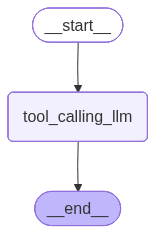

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! I'm a simple calculator. I can multiply two numbers for you. What would you like to do?


In [33]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
messages


{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='32122bbd-d38f-409b-b00a-d61c7810600c'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2, "b": 3}'}, '__gemini_function_call_thought_signatures__': {'66c984c2-3582-4481-8b03-25eaa416180d': 'CsoBAXLI2nwiftgCteV0VHtPIrD+1V9t/WvJhR1R/OYx511fPtqLu4fUkKc/8iF6S8YP36iY+1uBEE0KlsIz4uTPxWdwmnDqh8+glA+KaPgZYDJ8VMP1p7wU6DOEw3uJYKFkAfvKUGYa1lpOnhM8S80gmyf3tmvyiyYWbjP4xUi5IEQgZmZoMuNgt9YITjdZeUKQYi1zU1Z0nysQSCTPkwb0GCzdnOgk7QHXS/IDJ9rt4gdIdnApjIj9D2sHlJhxCAD6s9t86xDDcmM5PA=='}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--88b73e58-e7d2-4d2f-813b-6014692e5dc5-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': '66c984c2-3582-4481-8b03-25eaa416180d', 'type': 'tool_cal